# Text Classification with Naive Bayes, Logistic Regression, SVM

In [1]:
import numpy as np
import pandas as pd #to work with csv files

#matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

#import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words

#pre-processing of text
import string
import re

#import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

#import time function from time module to track the training duration
from time import time

d:\miniconda3\envs\env_pracnlp\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# STEP 1 - load data
our_data = pd.read_csv("Data/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

display(our_data.shape) #Number of rows (instances) and columns in the dataset
# imbalance dataset
our_data["relevance"].value_counts()/our_data.shape[0] #Class distribution in the dataset

(8000, 15)

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

In [3]:
# convert label to a numerical variable
our_data = our_data[our_data.relevance != "not sure"]
our_data.shape
our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0}) #relevant is 1, not-relevant is 0. 
our_data = our_data[["text","relevance"]] #Let us take only the two columns we need.
our_data.shape

(7991, 2)

In [4]:
# STEP 2 - Pre-processing
stopwords = stop_words.ENGLISH_STOP_WORDS
def clean(doc): #doc is a string of text
    doc = doc.replace("</br>", " ") #This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    #remove punctuation and numbers
    return doc

In [5]:
# STEP 3 - Modeling
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

#Step 1: train-test split
X = our_data.text #the column text contains textual data to extract features from
y = our_data.relevance #this is the column we are learning to predict. 
print(X.shape, y.shape)
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
#random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#Step 2-3: Preprocess and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean) #instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)#use it to extract features from training data
#transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)
#i.e., the dimension of our feature vector is 49753!

#Step 3: Train the classifier and predict for test data
nb = MultinomialNB() #instantiate a Multinomial Naive Bayes model
print('Training the model..')
%time nb.fit(X_train_dtm, y_train)#train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm)#make class predictions for X_test_dtm

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)
(5993, 49753) (1998, 49753)
Training the model..
Wall time: 6.05 ms


Accuracy:  0.7822822822822822
ROC_AOC_Score:  0.7251117679464362


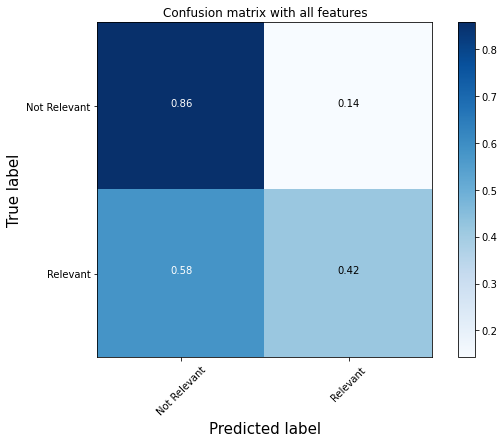

In [6]:
#Step 4: Evaluate the classifier using various measures

# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    
    
#Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

    
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
#Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

The model poorly predict the Relevant class with only 42% correct.

In order to solve that, we change max_features in CountVectorizer to 5000

Wall time: 1.99 ms
Accuracy:  0.6881881881881882


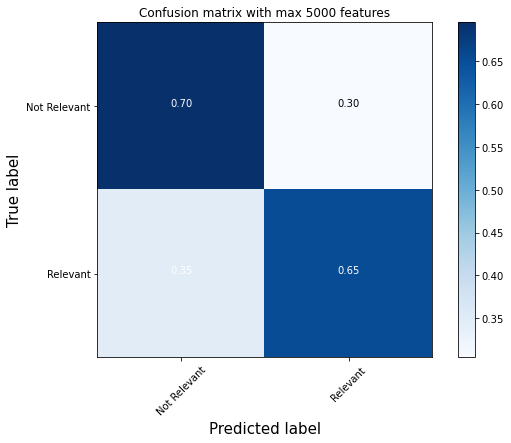

In [7]:
vect = CountVectorizer(preprocessor=clean, max_features=5000) #Step-1
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB() #instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train)#train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm)#make class predictions for X_test_dtm
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with max 5000 features')

The performance in Relevant class got better even though the overall accuracy drop by 10%.

We can try change the algorithm, using LogisticRegression and LinearSVC.

Accuracy:  0.7367367367367368
AUC:  0.7251117679464362


d:\miniconda3\envs\env_pracnlp\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


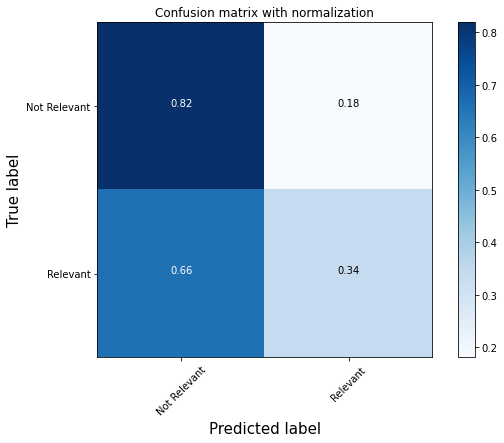

In [8]:
from sklearn.linear_model import LogisticRegression #import

logreg = LogisticRegression(class_weight="balanced") #instantiate a logistic regression model
logreg.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

Try another algorithm LinearSVC.

Accuracy:  0.6896896896896897
AUC:  0.7251117679464362


d:\miniconda3\envs\env_pracnlp\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


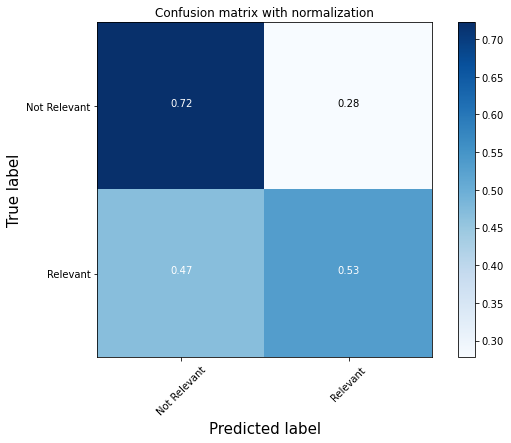

In [9]:
from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor=clean, max_features=1000) #Step-1
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced') #instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

So, what's the best model to choose?

It depends on what we are looking for in our usecase. If we want to make model that good at predicting 'relevant' class, we should choose the second one.